In [2]:
from Linearity import Neuron
%matplotlib notebook
import glob
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

In [10]:
fileList = ["/media/sahil/NCBS_Shares_BGStim/patch_data/161013/c1/plots/c1.pkl"]

In [3]:
fileList = glob.glob("/media/sahil/NCBS_Shares_BGStim/patch_data/**/c?/plots/*.pkl")
with open("/media/sahil/NCBS_Shares_BGStim/patch_data/CPP_files.txt", 'r') as fp:
    fileList = fp.read().splitlines()
    for i,filename in enumerate(fileList):
        fileList[i] += "plots/" + filename.split('/')[-2] + ".pkl"

In [4]:
def getNumBins(X, rule="S"):

    if rule == "FD":
        # Freedman‐Diaconis Rule!
        minMax = max(X) - min(X)
        Qx = sp.stats.iqr(X)
        N_cubrt = np.cbrt(len(X))
        print minMax, Qx, N_cubrt, minMax/(2.* Qx * N_cubrt)
        return int(np.ceil(minMax/(2.* Qx * N_cubrt)))
    elif rule == "S":
        # Sturges’ Rule!
        return int(np.ceil(1. + np.log2(len(X))))

def calc_MI(X,Y,bins):

    c_X = np.histogram(X, bins=bins)[0]
    c_Y = np.histogram(Y, bins=bins)[0]
    c_XY = np.histogram2d(X,Y, bins=bins)[0]

    H_X = shan_entropy(c_X)
    H_Y = shan_entropy(c_Y)
    H_XY = shan_entropy(c_XY)

    MI = H_X + H_Y - H_XY
    normalized_MI = MI    # In bits, or normalize: /(np.sqrt(H_X*H_Y))
    return normalized_MI

def calc_TI(X,Y,Z,bins):

    c_X = np.histogram(X, bins=bins)[0]
    c_Y = np.histogram(Y, bins=bins)[0]
    c_Z = np.histogram(Z, bins=bins)[0]

    c_XY = np.histogram2d(X,Y, bins=bins)[0]
    c_XYZ = np.histogramdd((X,Y,Z), bins=bins)[0]

    H_X = shan_entropy(c_X)
    H_Y = shan_entropy(c_Y)
    H_Z = shan_entropy(c_Z)

    H_XY = shan_entropy(c_XY)
    H_XYZ = shan_entropy(c_XYZ)

    TI = H_Z + H_XY - H_XYZ
    normalized_TI = TI  # In bits, or normalize: /(np.sqrt(H_X*H_Y))
    return normalized_TI


def shan_entropy(c):
    c_normalized = c / float(np.sum(c))
    c_normalized = c_normalized[np.nonzero(c_normalized)]
    H = -sum(c_normalized* np.log2(c_normalized))
    return H

In [5]:
mitm, miom, g_mitm, g_miom, c_mitm, c_miom, iqr, g_iqr, c_iqr, c_t_mi, t_mi, g_t_mi = [],[],[],[],[],[],[],[],[],[],[],[]
for filename in fileList:
    #filename = "/media/sahil/NCBS_Shares_BGStim/patch_data/170317/c1_spikes/plots/c1_spikes.pkl"
    neuron = Neuron.load(filename)
    for experiment in neuron.experiment:
        maximum, max_observed, real_maximum, time, max_for_trials, time_for_trials, real_time, num_square = [], [], [], [], [], [], [], []
        #if not experiment == "Control":
        print "Cell {} on date {}, {}".format(neuron.index, neuron.date, experiment)
        for numSq in neuron.experiment[experiment]:
            if numSq>1:
                coordwise = neuron.experiment[experiment][numSq].coordwise
                for coord in coordwise:
                    #max_for_trials = []
                    for trial in coordwise[coord].trials:
                        try:
                            if not trial.AP_flag:
                                maximum.append(coordwise[coord].expected_feature[0])
                                time.append(coordwise[coord].average_feature[3]*1e3)
                                max_for_trials.append(trial.feature[0])
                                max_observed.append(coordwise[coord].average_feature[0])
                                num_square.append(numSq)
                                time_for_trials.append(trial.feature[3]*1e3)
                        except:
                            print "oopsie"
                                
                    #if len(max_for_trials):
                    #    real_maximum.append(sum(max_for_trials)/len(max_for_trials))
                    #    real_time.append(coordwise[coord].average_feature[3]*1e3)
        #fig, ax = plt.subplots(1,2)
        #ax[0].scatter(maximum, time, c=num_square, cmap='plasma')
        #ax[1].scatter(real_maximum, real_time, cmap='plasma')
        #plt.show()

        #ax1 = plt.subplot(121)
        #ax1.scatter(time, maximum,  c=num_square, cmap='viridis')
        #ax1.set_xlabel("$t_{peak}$ observed")
        #ax1.set_ylabel("$V_{max}$ expected")
        #ax1.set_xlim((5,40))
        
        #ax2 = plt.subplot(122, sharey=ax1)
        #ax2.scatter(max_observed, maximum, c=num_square, cmap='viridis')
        #ax2.set_xlabel("$V_{max}$ observed")
        
        #ax[1][0].scatter(time_for_trials, maximum,  c=num_square, cmap='plasma')
        #ax[1][1].scatter(max_for_trials, maximum, cmap='plasma')
        #plt.title("{} Total input predictors".format(experiment))
        #plt.show()
        #plt.savefig("analyzed_temp/time_to_peak/{}_{}_{}.png".format(neuron.index, neuron.date, experiment))
        #plt.close()
        
        time = np.array([x for (y,x) in sorted(zip(maximum,time))])
        max_observed = np.array([x for (y,x) in sorted(zip(maximum,max_observed))])
        maximum = np.array(sorted(maximum))

        I_te = []
        I_oe = []
        I_ote = []
        bins = 5        
        windowSize = 2.5 #mV
        windowSlide = 2
        
        if len(maximum):
            #print "Numbins are ", getNumBins(maximum)
            numBins = getNumBins(maximum)
            windowBins = np.arange(0,max(maximum), windowSize)
            binnedMaximum = np.digitize(maximum, windowBins,right=True)

            windowRange = np.array(sorted(list(set(binnedMaximum))))
            #windows = range(0,len(maximum) - windowSize + 1, stepsize)

            for i,w in enumerate(windowRange[:-1]):
                indices = np.where( (binnedMaximum == w) | (binnedMaximum == windowRange[i+1]))
                I_te.append(calc_MI(time[indices], maximum[indices],bins))
                I_oe.append(calc_MI(max_observed[indices], maximum[indices],bins))
                I_ote.append(calc_TI(time[indices],max_observed[indices], maximum[indices],bins))

            #print I_te, I_oe
            I_sum = np.array(I_te) + np.array(I_oe)
            #plt.plot(windowRange[:-1]*windowSize, I_te, label="te")
            #plt.plot(windowRange[:-1]*windowSize, I_oe, label="oe")
            #plt.plot(windowRange[:-1]*windowSize, I_ote, label="ote")
            #plt.ylim(ymin=0)
            #plt.xlim(xmin=0)
            #plt.plot(windowRange*windowSize, I_sum, label="Sum")


            #plt.legend()
            #plt.savefig("analyzed_temp/time_to_peak/Information_{}_{}_{}.png".format(neuron.index, neuron.date, experiment))
            #plt.show()
            #plt.close()
            #ax1 = plt.subplot(121)
            #ax1.scatter(time, maximum,  c=num_square, cmap='viridis')
            #ax1.set_xlabel("$t_{peak}$ observed")
            #ax1.set_ylabel("$V_{max}$ expected")
            #ax1.set_xlim((5,40))

            #ax2 = plt.subplot(122, sharey=ax1)
            #ax2.scatter(max_observed, maximum, c=num_square, cmap='viridis')
            #ax2.set_xlabel("$V_{max}$ observed")

            #ax[1][0].scatter(time_for_trials, maximum,  c=num_square, cmap='plasma')
            #ax[1][1].scatter(max_for_trials, maximum, cmap='plasma')
            #plt.title("{} Total input predictors".format(experiment))
            #plt.show()
            
            if len(neuron.experiment) == 1:
                mitm.append(calc_MI(time, maximum, numBins))
                miom.append(calc_MI(max_observed, maximum, numBins))
                t_mi.append(calc_TI(time, max_observed, maximum, numBins))
                iqr.append(sp.stats.iqr(maximum))
            else:
                if experiment == "Control":
                    mitm.append(calc_MI(time, maximum, numBins))
                    miom.append(calc_MI(max_observed, maximum, numBins))
                    t_mi.append(calc_TI(time, max_observed, maximum, numBins))
                    iqr.append(sp.stats.iqr(maximum))
                    
                    c_mitm.append(calc_MI(time, maximum, numBins))
                    c_miom.append(calc_MI(max_observed, maximum, numBins))
                    c_t_mi.append(calc_TI(time, max_observed, maximum, numBins))
                    c_iqr.append(sp.stats.iqr(maximum))
                elif experiment == "GABAzine":
                    g_mitm.append(calc_MI(time, maximum, numBins))
                    g_miom.append(calc_MI(max_observed, maximum, numBins))
                    g_t_mi.append(calc_TI(time, max_observed, maximum, numBins))
                    g_iqr.append(sp.stats.iqr(maximum))

Cell c2 on date 150828, Control
Cell c1 on date 150902, Control
Cell c2 on date 150902, Control
Cell c1 on date 150904, Control
Cell c3 on date 150904, Control
Cell c3 on date 160126, Control
Cell c4 on date 160209, Control
Cell c5 on date 160219, Control
Cell c2 on date 160223, Control
Cell c3 on date 160223, Control
Cell c5 on date 160513, Control
Cell c5 on date 160617, Control
Cell c2 on date 160817, Control
Cell c1 on date 160830, Control
Cell c1 on date 160830, GABAzine
Cell c1 on date 160920, Control
Cell c1 on date 160920, GABAzine
Cell c1 on date 160927, Control
Cell c1 on date 160927, GABAzine
Cell c3 on date 160927, Control
Cell c5 on date 160927, Control
Cell c5 on date 160927, GABAzine
oopsie
oopsie
Cell c3 on date 160928, Control
Cell c4 on date 160928, Control
Cell c4 on date 160928, GABAzine
Cell c1 on date 161013, Control
Cell c1 on date 161013, GABAzine
Cell c1 on date 161026, Control
Cell c3 on date 161027, Control
Cell c3 on date 161027, GABAzine
oopsie
Cell c3 on d

In [19]:
c_mitm, c_miom, c_t_mi, g_mitm, g_miom, g_t_mi, mitm, miom, t_mi, iqr = np.array(c_mitm), np.array(c_miom), np.array(c_t_mi), np.array(g_mitm), np.array(g_miom), np.array(g_t_mi), np.array(mitm), np.array(miom), np.array(t_mi), np.array(iqr)

<IPython.core.display.Javascript object>


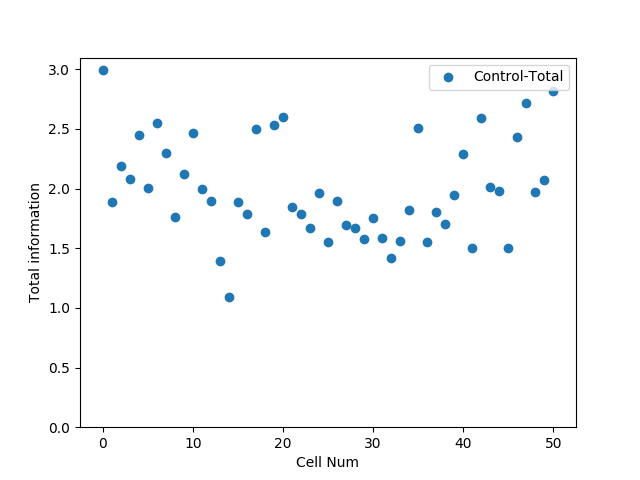

In [66]:
ax = plt.subplot()
ax.scatter(range(len(t_mi)),t_mi, label="Control-Total")
ax.set_xlabel("Cell Num")
ax.set_ylabel("Total information")
ax.set_ylim(ymin=0)
ax.legend()
plt.show()

### IQR: Inter quartile range is the range of the distribution where 25% to 75% of the data lies. It is agnostic to the distribution that is being sampled from (unlike variance which assumes normality)

<IPython.core.display.Javascript object>


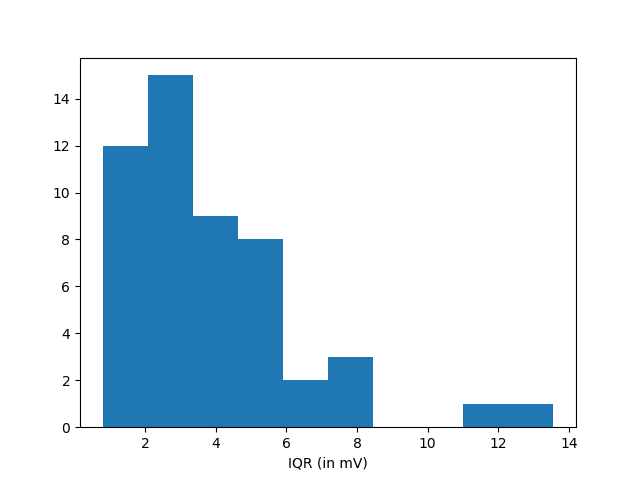

In [89]:
plt.hist(iqr)
plt.xlabel("IQR (in mV)")
plt.show()

<IPython.core.display.Javascript object>


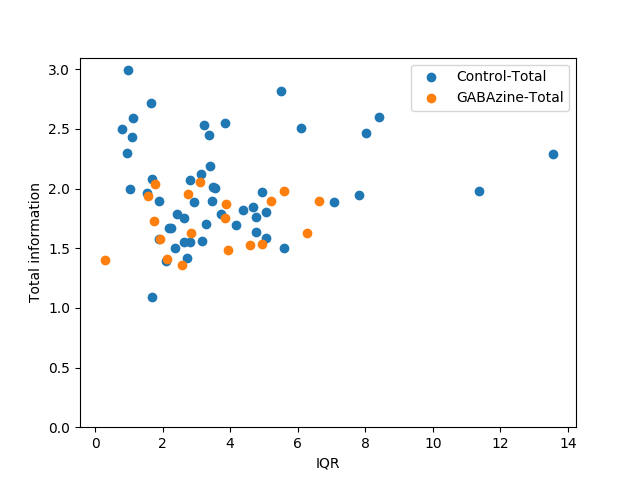

In [79]:
ax = plt.subplot()
ax.scatter(iqr, t_mi, label="Control-Total")
ax.scatter(g_iqr, g_t_mi, label="GABAzine-Total")
ax.set_xlabel("IQR")
ax.set_ylabel("Total information")
ax.set_ylim(ymin=0)
ax.legend()
plt.show()

MI for GABAzine expected maximum and time decreases and MI for GABAzine expected maximum and observed amplitude increases with larger IQR.

<IPython.core.display.Javascript object>


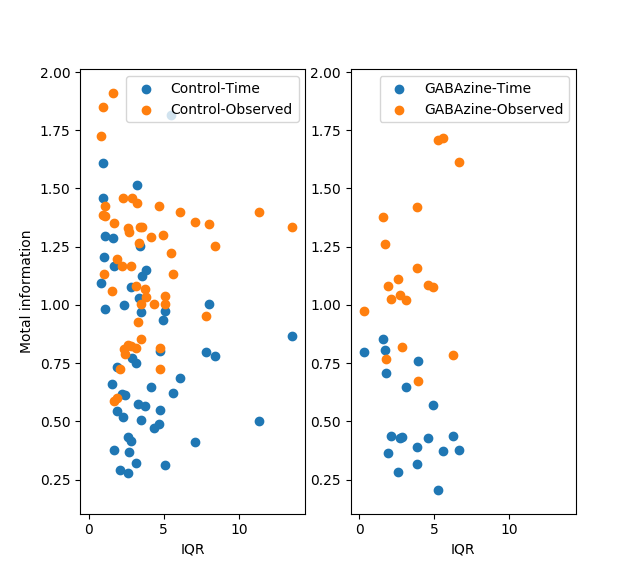

In [90]:
ax = plt.subplot(121)
ax.scatter(iqr, mitm, label="Control-Time")
ax.scatter(iqr, miom, label="Control-Observed")
ax2 = plt.subplot(122, sharex=ax,sharey=ax)
ax2.scatter(g_iqr, g_mitm, label="GABAzine-Time")
ax2.scatter(g_iqr, g_miom, label="GABAzine-Observed")
ax.set_xlabel("IQR")
ax2.set_xlabel("IQR")
ax.set_ylabel("Motal information")
ax.legend()
ax2.legend()
plt.show()

<IPython.core.display.Javascript object>


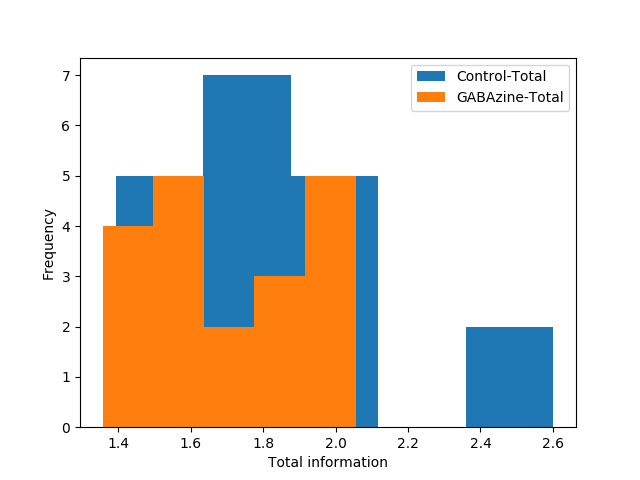

In [78]:
ax = plt.subplot()
ax.hist(c_t_mi, label="Control-Total", bins=5)
ax.hist(g_t_mi, label="GABAzine-Total", bins=5)
ax.set_xlabel("Total information")
ax.set_ylabel("Frequency")
ax.legend()
plt.show()

<IPython.core.display.Javascript object>


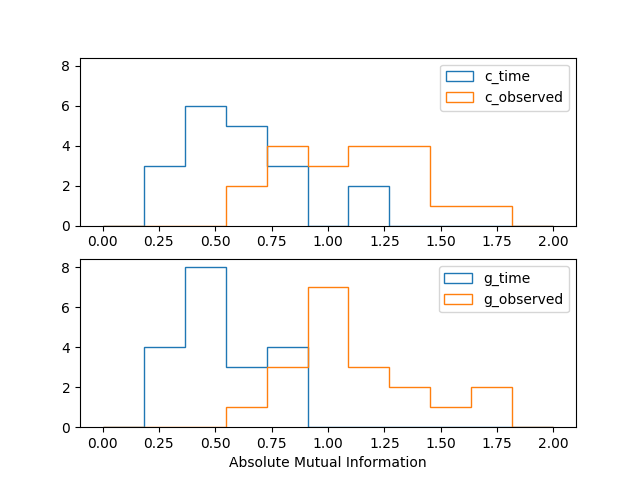

In [85]:
numBins = 12
histtype=['bar','step'][1]
alpha =1
bins = np.linspace(0., 2.0, numBins)
ax = plt.subplot(211)
ax.hist(c_mitm, label="c_time", bins=bins, alpha=alpha, histtype=histtype)
ax.hist(c_miom, label="c_observed", bins=bins, alpha=alpha, histtype=histtype)
ax.legend()
ax2 = plt.subplot(212, sharex=ax, sharey=ax)
ax2.hist(g_mitm, bins=bins, label="g_time", alpha=alpha, histtype=histtype)
ax2.hist(g_miom, bins=bins, label="g_observed", alpha=alpha, histtype=histtype)
ax2.legend()
ax2.set_xlabel("Absolute Mutual Information")
plt.show()

### Unsorted control observed, and time to look at the relative change between MI of Observed and Time to expected.

<IPython.core.display.Javascript object>


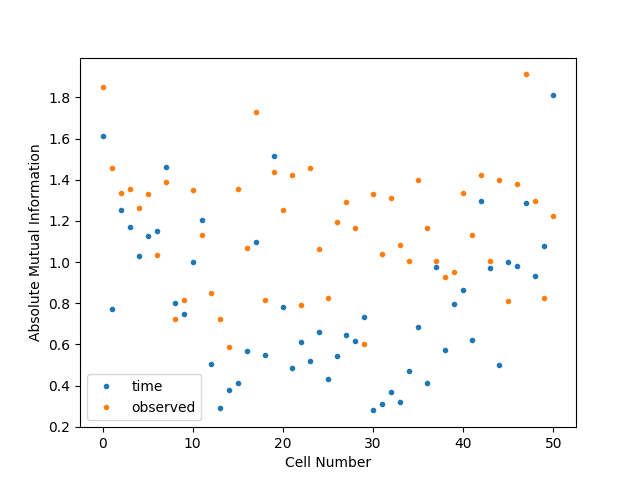

In [92]:
ax = plt.subplot()
ax.plot(mitm, '.', label="time", alpha=1)
ax.plot(miom, '.', label="observed", alpha=1)
ax.set_xlabel("Cell Number")
ax.set_ylabel("Absolute Mutual Information")
ax.legend()
plt.show()

### Sorted control observed, and time to look at the relative change between MI of Observed and Time to expected.

<IPython.core.display.Javascript object>


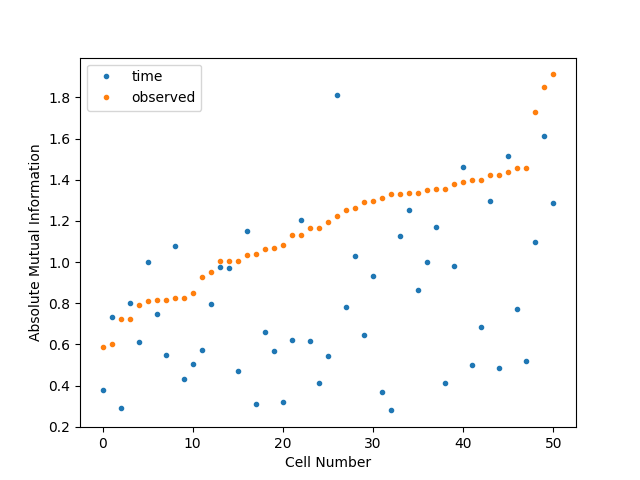

In [93]:
idx = np.argsort(miom)
miom_s = miom[idx]
mitm_s = mitm[idx]

ax = plt.subplot()
ax.set_xlabel("Cell Number")
ax.set_ylabel("Absolute Mutual Information")
ax.plot(mitm_s, '.', label="time", alpha=1)
ax.plot(miom_s, '.', label="observed", alpha=1)
ax.legend()
plt.show()

### Same thing with GABAzine

<IPython.core.display.Javascript object>


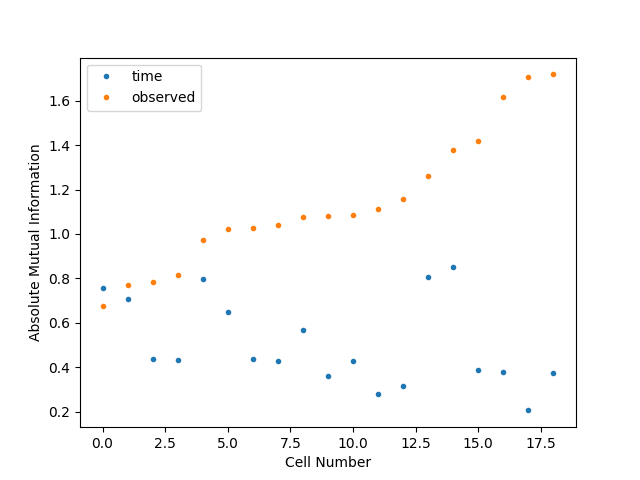

In [94]:
g_miom_s = [x for (x,y) in sorted(zip(g_miom, g_mitm))]
g_mitm_s = [y for (x,y) in sorted(zip(g_miom, g_mitm))]
ax = plt.subplot()
ax.plot(g_mitm_s, '.', label="time", alpha=1)
ax.plot(g_miom_s, '.', label="observed", alpha=1)
ax.set_xlabel("Cell Number")
ax.set_ylabel("Absolute Mutual Information")
ax.legend()
plt.show()

In terms of absolute (unnormalized) information in time, timing is negatively correlated with expected $v_{max}$ and observed is positively correlated.

### Same thing with gabazine partnered control

<IPython.core.display.Javascript object>


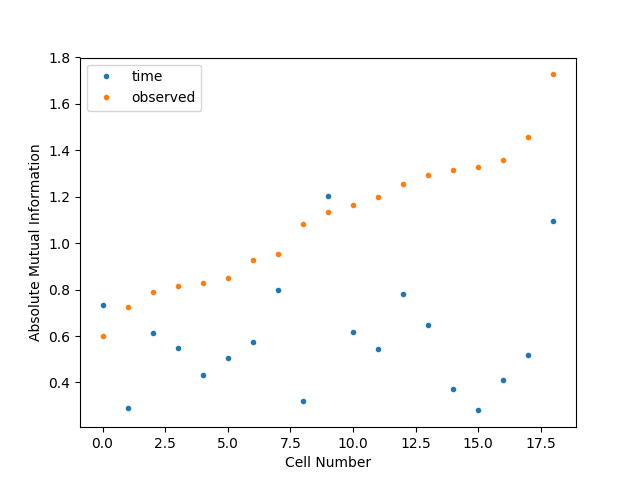

In [95]:
c_miom_s = [x for (x,y) in sorted(zip(c_miom, c_mitm))]
c_mitm_s = [y for (x,y) in sorted(zip(c_miom, c_mitm))]
ax = plt.subplot()
ax.plot(c_mitm_s, '.', label="time", alpha=1)
ax.plot(c_miom_s, '.', label="observed", alpha=1)
ax.set_xlabel("Cell Number")
ax.set_ylabel("Absolute Mutual Information")
ax.legend()
plt.show()

### Same as above, normalized to total information

<IPython.core.display.Javascript object>


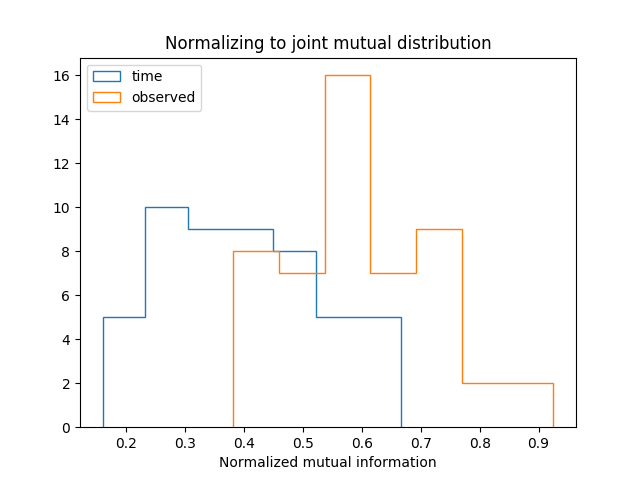

In [91]:
ax = plt.subplot()
ax.set_title("Normalizing to joint mutual distribution")
ax.hist(mitm/t_mi, bins=7, label="time", alpha=1, histtype='step')
ax.hist(miom/t_mi, bins=7, label="observed", alpha=1, histtype='step')
ax.legend()
ax.set_xlabel("Normalized mutual information")
plt.show()

### Sorted control observed, and time to look at the relative change between MI (O,E) and MI(T,E).

<IPython.core.display.Javascript object>


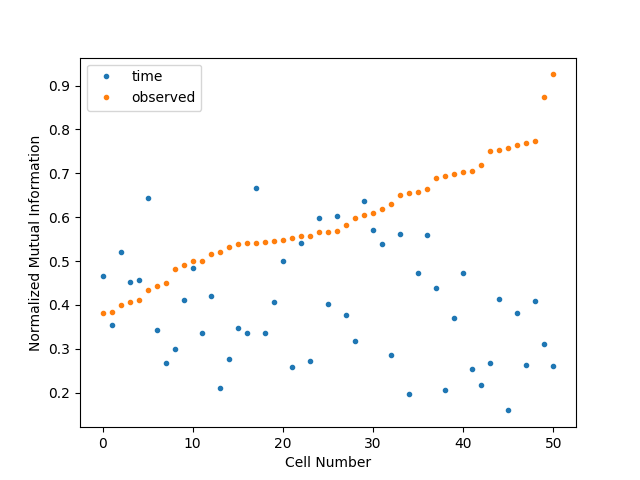

In [118]:
idx = np.argsort(miom/t_mi)

miom_s = miom[idx]/t_mi[idx]
mitm_s = mitm[idx]/t_mi[idx]
iqr_s = iqr[idx]

ax = plt.subplot()
ax.plot(mitm_s, '.', label="time", alpha=1)
ax.plot(miom_s, '.', label="observed", alpha=1)
ax.set_xlabel("Cell Number")
ax.set_ylabel("Normalized Mutual Information")
ax.legend()
plt.show()

<IPython.core.display.Javascript object>


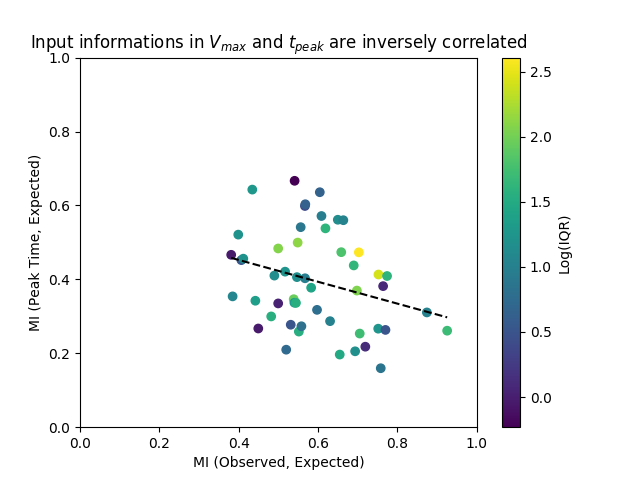

In [62]:
fit = np.polyfit(miom_s,mitm_s,1)
fit_fn = np.poly1d(fit)

f,ax = plt.subplots()
sc = ax.scatter(miom_s,mitm_s, alpha=1, c=np.log(iqr))
ax.set_xlabel("MI (Observed, Expected)")
ax.set_ylabel("MI (Peak Time, Expected)")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot(miom_s, fit_fn(miom_s), '--k')
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('Log(IQR)')
plt.title("Input informations in $V_{max}$ and $t_{peak}$ are inversely correlated")
plt.show()

### Same thing with GABAzine

<IPython.core.display.Javascript object>


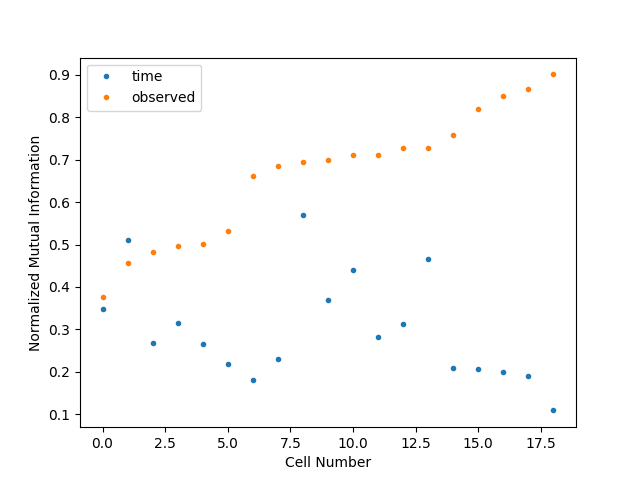

In [117]:
idx = np.argsort(g_miom/g_t_mi)

g_miom_s = g_miom[idx]/g_t_mi[idx]
g_mitm_s = g_mitm[idx]/g_t_mi[idx]

ax = plt.subplot()
ax.plot(g_mitm_s, '.', label="time", alpha=1)
ax.plot(g_miom_s, '.', label="observed", alpha=1)
ax.set_xlabel("Cell Number")
ax.set_ylabel("Normalized Mutual Information")
ax.legend()
plt.show()

In terms of absolute (unnormalized) information in time, timing is negatively correlated with expected $v_{max}$ and observed is positively correlated.

### Same thing with gabazine partnered control

<IPython.core.display.Javascript object>


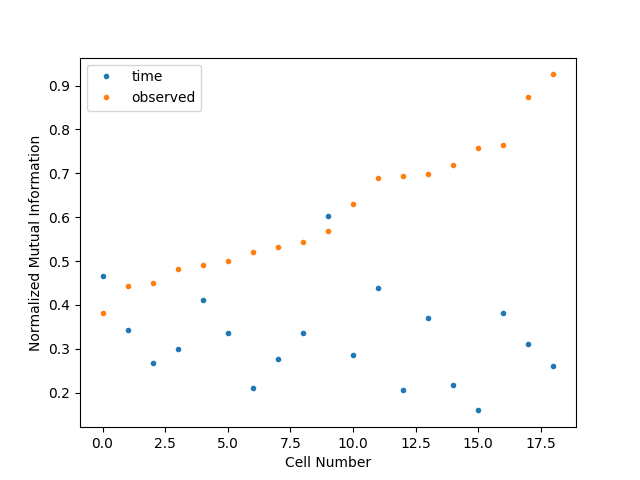

In [116]:
idx = np.argsort(c_miom/c_t_mi)

c_miom_s = c_miom[idx]/c_t_mi[idx]
c_mitm_s = c_mitm[idx]/c_t_mi[idx]

ax = plt.subplot()
ax.plot(c_mitm_s, '.', label="time", alpha=1)
ax.plot(c_miom_s, '.', label="observed", alpha=1)
ax.set_xlabel("Cell Number")
ax.set_ylabel("Normalized Mutual Information")
ax.legend()
plt.show()

### With IQR (Inter quartile range) based filter

In [119]:
iqr_filter = 2.0
idx = np.array([i for i,x in enumerate(iqr) if x> iqr_filter ])
mitm_ = mitm[idx]
miom_ = miom[idx]
t_mi_ = t_mi[idx]

idx = np.array([i for i,x in enumerate(c_iqr) if x> iqr_filter])
c_mitm_ = c_mitm[idx]
c_miom_ = c_miom[idx]
g_mitm_ = g_mitm[idx]
g_miom_ = g_miom[idx]
c_t_mi_ = c_t_mi[idx]
g_t_mi_ = g_t_mi[idx]

<IPython.core.display.Javascript object>


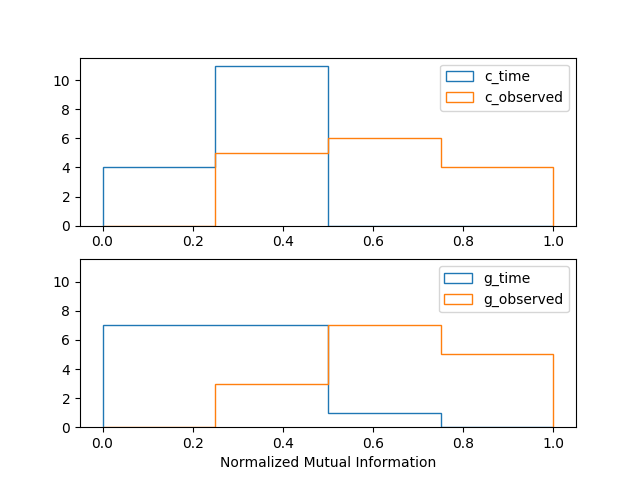

In [120]:
numBins = getNumBins(c_t_mi_)
histtype=['bar','step'][1]
alpha =1
bins = np.linspace(0., 1., numBins)
ax = plt.subplot(211)
ax.hist(c_mitm_/c_t_mi_, label="c_time", bins=bins, alpha=alpha, histtype=histtype)
ax.hist(c_miom_/c_t_mi_, label="c_observed", bins=bins, alpha=alpha, histtype=histtype)
#ax.hist(c_t_mi, label="c_total", bins=bins, alpha=alpha, histtype=histtype)
ax.legend()
ax2 = plt.subplot(212, sharex=ax, sharey=ax)
ax2.hist(g_mitm_/g_t_mi_, bins=bins, label="g_time", alpha=alpha, histtype=histtype)
ax2.hist(g_miom_/g_t_mi_, bins=bins, label="g_observed", alpha=alpha, histtype=histtype)
#ax2.hist(g_t_mi, label="g_total", bins=bins, alpha=alpha, histtype=histtype)
ax2.legend()
ax2.set_xlabel("Normalized Mutual Information")
plt.show()

### Sorted control observed, and time to look at the relative change between MI of Observed and Time to expected.

<IPython.core.display.Javascript object>


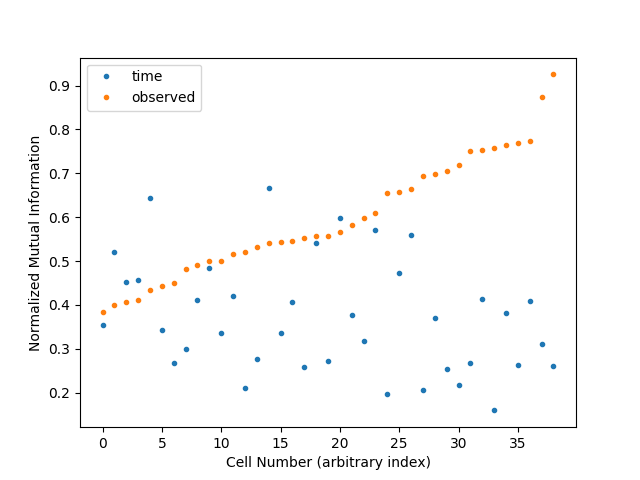

In [121]:
idx = np.argsort(miom_/t_mi_)

miom_s = miom_[idx]/t_mi_[idx]
mitm_s = mitm_[idx]/t_mi_[idx]
ax = plt.subplot(111)
ax.plot(mitm_s, '.', label="time", alpha=1)
ax.plot(miom_s, '.', label="observed", alpha=1)
ax.set_xlabel("Cell Number (arbitrary index)")
ax.set_ylabel("Normalized Mutual Information")
ax.legend()
plt.show()

### We see an inverse relationship between mutual information OE, with TE.

<IPython.core.display.Javascript object>


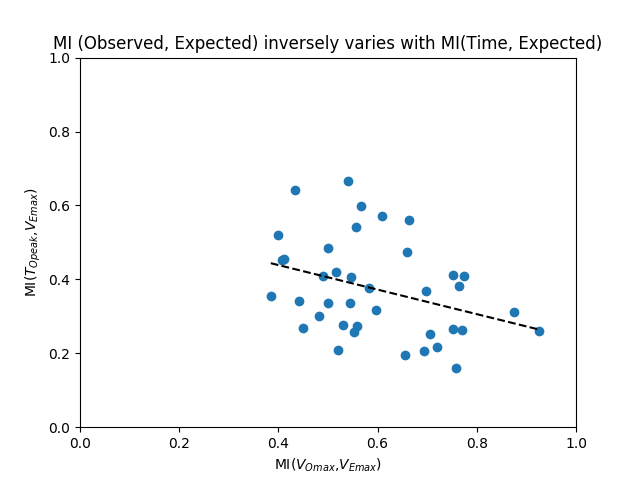

In [122]:
fit = np.polyfit(miom_s,mitm_s,1)
fit_fn = np.poly1d(fit)

ax = plt.subplot(111)
ax.scatter(miom_s,mitm_s, alpha=1)
ax.set_xlabel("MI($V_{Omax}$,$V_{Emax}$)")
ax.set_ylabel("MI($T_{Opeak}$,$V_{Emax}$)")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot(miom_s, fit_fn(miom_s), '--k')
plt.title("MI (Observed, Expected) inversely varies with MI(Time, Expected)")
plt.show()

### Same thing with GABAzine

<IPython.core.display.Javascript object>


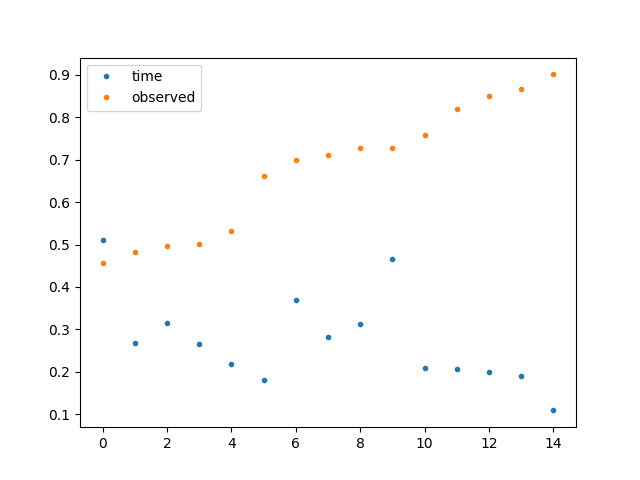

In [123]:
idx = np.argsort(g_miom_/g_t_mi_)

g_miom_s = g_miom_[idx]/g_t_mi_[idx]
g_mitm_s = g_mitm_[idx]/g_t_mi_[idx]

ax = plt.subplot()
ax.plot(g_mitm_s, '.', label="time", alpha=1)
ax.plot(g_miom_s, '.', label="observed", alpha=1)

ax.legend()
plt.show()

<IPython.core.display.Javascript object>


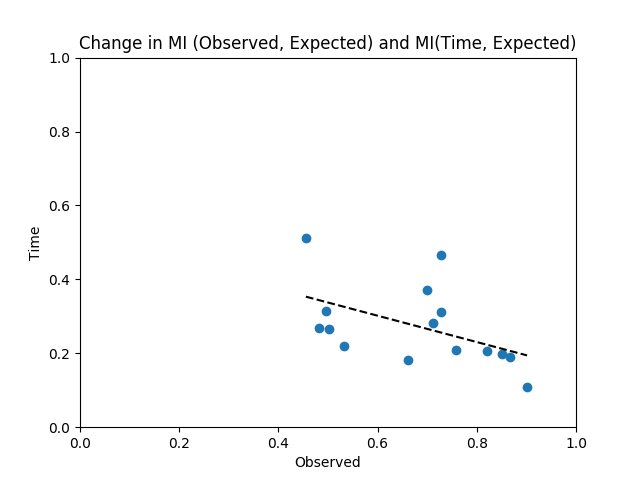

In [124]:
fit = np.polyfit(g_miom_s,g_mitm_s,1)
fit_fn = np.poly1d(fit)

ax = plt.subplot(111)
ax.scatter(g_miom_s,g_mitm_s, alpha=1)
ax.set_xlabel("Observed")
ax.set_ylabel("Time")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot(g_miom_s, fit_fn(g_miom_s), '--k')
plt.title("Change in MI (Observed, Expected) and MI(Time, Expected)")
plt.show()

In terms of absolute (unnormalized) information in time, timing is negatively correlated with expected $v_{max}$ and observed is positively correlated.

### Same thing with gabazine partnered control

<IPython.core.display.Javascript object>


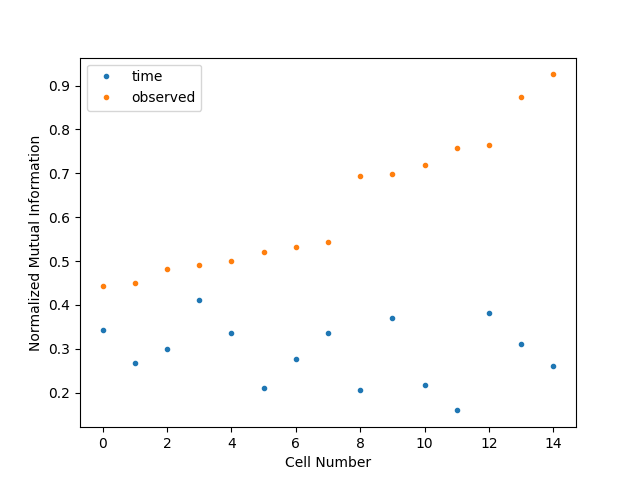

In [125]:
idx = np.argsort(c_miom_/c_t_mi_)

c_miom_s = c_miom_[idx]/c_t_mi_[idx]
c_mitm_s = c_mitm_[idx]/c_t_mi_[idx]

ax = plt.subplot()
ax.plot(c_mitm_s, '.', label="time", alpha=1)
ax.plot(c_miom_s, '.', label="observed", alpha=1)
ax.set_xlabel("Cell Number")
ax.set_ylabel("Normalized Mutual Information")
ax.legend()
plt.show()

<IPython.core.display.Javascript object>


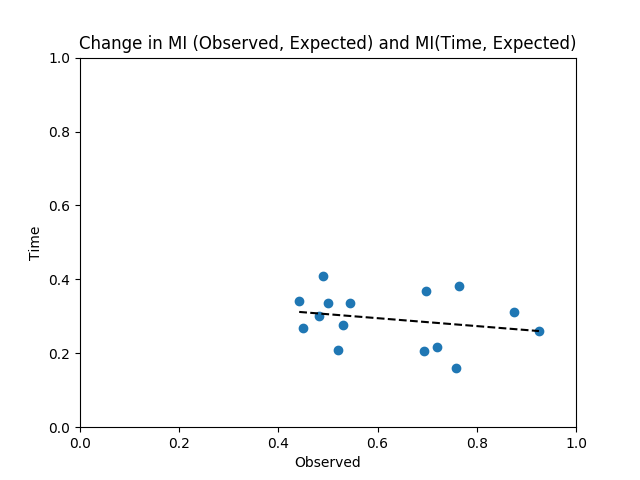

In [126]:
fit = np.polyfit(c_miom_s,c_mitm_s,1)
fit_fn = np.poly1d(fit)

ax = plt.subplot(111)
ax.scatter(c_miom_s,c_mitm_s, alpha=1)
ax.set_xlabel("Observed")
ax.set_ylabel("Time")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.plot(c_miom_s, fit_fn(c_miom_s), '--k')
plt.title("Change in MI (Observed, Expected) and MI(Time, Expected)")
plt.show()